<a href="https://colab.research.google.com/github/ckgpeace/EVA5B2/blob/main/S6/Session6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      # transforms.Resize((28, 28)),                                      
                                      # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations - No transformation in the test data
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Data Statistics

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
torch.Size([128, 1, 28, 28])
torch.Size([128])


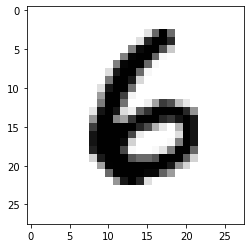

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already while loading the dataset
train_data = train.train_data
train_data = train.transform(train_data.numpy())


print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

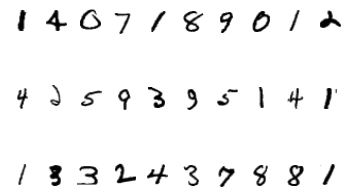

In [6]:
figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(3, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

**1.   Target**
- Changing the architecture to accomodate one 16x16 channel to capture complexity while keeping the number of paramaters less than 8K

**2. Results**

- The number of parameters has reduced to 7,996
- The test accuracy is above 99.42 in 15 epoch and consistently around 99.35 in last 4-5 epochs out of 15 epochs

**3. Analysis**

- Using 16 x 16 channel has incresed the accuracy as it can capture more complex feartures from the data
- We need small number of channels in initial layers as we intend to capture simpler features like edges and gradients and large number of channels in later later layers to capture complex features like patterns and object

In [7]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 28


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24
     

        # TRANSITION BLOCK 1
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12


        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6      
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 4

        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            # nn.AvgPool2d(kernel_size=4)
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)

        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)

        x = self.convblock5(x)
        x = self.pool1(x)

        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)        
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 26, 26]             576
             ReLU-10            [-1, 8, 26, 26]               0
      BatchNorm2d-11            [-1, 8, 26, 26]              16
          Dropout-12            [-1, 8, 26, 26]               0
           Conv2d-13           [-1, 12, 24, 24]             864
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, train_losses, train_acc, l1_decay=0, l2_decay=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    #L1 Regularization
    if l1_decay > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param,1)
      loss += l1_decay * l1_loss
    
    #L2 Regularization
    if l2_decay > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param,2)
      loss += l2_decay * l2_loss
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()[0]
                })
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [10]:
from torch.optim.lr_scheduler import StepLR

def run_model(l1_decay, l2_decay):        
    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
    
    EPOCHS = 20

    train_losses = []
    train_acc = []


    test_losses = []
    test_acc = []
    misclassified_imgs = []

    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch, train_losses, train_acc, l1_decay, l2_decay)
        # scheduler.step()
        test(model, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    return test_losses, test_acc, misclassified_imgs

In [11]:
test_losses_ = []
test_acc_ = []
misclassified_imgs_ = []

for i in ['NoReg', 'L1', 'L2', 'L1+L2']:
    if i == 'NoReg':
        print("No Regularization")
        test_losses, test_acc, misclassified_imgs = run_model(l1_decay=0, l2_decay=0)
        test_losses_.append(test_losses)
        test_acc_.append(test_acc)
        misclassified_imgs_.append(misclassified_imgs)
        print(test_losses)
    elif i == 'L1':
        print("L1 Regularization")
        test_losses, test_acc, misclassified_imgs = run_model(l1_decay=0.00005, l2_decay=0)
        test_losses_.append(test_losses)
        test_acc_.append(test_acc)
        misclassified_imgs_.append(misclassified_imgs)
    elif i == 'L2':
        print("L1 Regularization")
        test_losses, test_acc, misclassified_imgs = run_model(l1_decay=0, l2_decay=0.0005)
        test_losses_.append(test_losses)
        test_acc_.append(test_acc)
        misclassified_imgs_.append(misclassified_imgs)
    elif i == 'L1+L2':
        print("L1 and L2 Regularization")
        test_losses, test_acc, misclassified_imgs = run_model(l1_decay=0.00005, l2_decay=0.0005)
        test_losses_.append(test_losses)
        test_acc_.append(test_acc)
        misclassified_imgs_.append(misclassified_imgs)
        
    

  0%|          | 0/469 [00:00<?, ?it/s]

No Regularization
EPOCH: 0


Loss=0.08538570255041122 Batch_id=468 Accuracy=88.62: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Accuracy: 9806/10000 (98.06%)

EPOCH: 1


Loss=0.15035603940486908 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.07269978523254395 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.05526509881019592 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.06657365709543228 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.0115613779053092 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.022216027602553368 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.016972821205854416 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.024310529232025146 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.04188527166843414 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.044007882475852966 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:18<00:00, 25.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.04842735826969147 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.005876744631677866 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.08333005756139755 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.012005466036498547 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.029181309044361115 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.09471356868743896 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.024771759286522865 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 25.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.004577151034027338 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.0928582176566124 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

[0.0621021843701601, 0.04026756126880646, 0.03076635105535388, 0.03173846343513578, 0.02994808341860771, 0.029245431569218636, 0.02477893050014973, 0.022479485592991115, 0.02670302567258477, 0.023424733432754873, 0.01994885909296572, 0.02050137036256492, 0.021001969293504952, 0.023318559242086485, 0.02115749444263056, 0.019887460180372, 0.019849798699468374, 0.02023831028789282, 0.02480879326611757, 0.020095261286199092]
L1 Regularization
EPOCH: 0


Loss=0.18642747402191162 Batch_id=468 Accuracy=89.01: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9813/10000 (98.13%)

EPOCH: 1


Loss=0.1602334976196289 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.10271059721708298 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9833/10000 (98.33%)

EPOCH: 3


Loss=0.11256171762943268 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.06423523277044296 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.16599300503730774 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.09699801355600357 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.06644397974014282 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.09341756999492645 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.046802159398794174 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.06238245591521263 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9903/10000 (99.03%)

EPOCH: 11


Loss=0.08713901042938232 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.05291171371936798 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.057217225432395935 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.048138633370399475 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9915/10000 (99.15%)

EPOCH: 15


Loss=0.040893297642469406 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9907/10000 (99.07%)

EPOCH: 16


Loss=0.10168489813804626 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.04619259014725685 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.040509726852178574 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.037787728011608124 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]



Test set: Average loss: 0.0251, Accuracy: 9917/10000 (99.17%)

L1 Regularization


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08928787708282471 Batch_id=468 Accuracy=89.80: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0825, Accuracy: 9767/10000 (97.67%)

EPOCH: 1


Loss=0.1637832224369049 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9848/10000 (98.48%)

EPOCH: 2


Loss=0.12832793593406677 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.04670250788331032 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9859/10000 (98.59%)

EPOCH: 4


Loss=0.0521383099257946 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.04925137385725975 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.06852994859218597 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.07441754639148712 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.03504175692796707 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.05965588986873627 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.09426538646221161 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.06915692985057831 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.07374344021081924 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


Loss=0.039120107889175415 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.18720866739749908 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.0716579258441925 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.08425597846508026 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.08638699352741241 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.07384377717971802 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.11915864050388336 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]



Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)



  0%|          | 0/469 [00:00<?, ?it/s]

L1 and L2 Regularization
EPOCH: 0


Loss=0.17204546928405762 Batch_id=468 Accuracy=89.50: 100%|██████████| 469/469 [00:24<00:00, 19.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9811/10000 (98.11%)

EPOCH: 1


Loss=0.12032836675643921 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.11842939257621765 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.10363712906837463 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:24<00:00, 19.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.08525645732879639 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.08435022085905075 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.14859358966350555 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.14125503599643707 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.11487980931997299 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.10960794240236282 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.08177121728658676 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9911/10000 (99.11%)

EPOCH: 11


Loss=0.15909138321876526 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.06817109137773514 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:25<00:00, 18.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.06767375767230988 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:24<00:00, 19.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.10382941365242004 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:24<00:00, 18.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.07869607210159302 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:24<00:00, 18.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.14027437567710876 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:24<00:00, 19.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9896/10000 (98.96%)

EPOCH: 17


Loss=0.10863261669874191 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.07618451118469238 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)

EPOCH: 19


Loss=0.09294234961271286 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]



Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)



# Ploting misclassified images

In [12]:
def plot_misclassified_images(img_data, img_name):
  figure = plt.figure(figsize=(10, 10))
  num_of_images = len(img_data)
  for index in range(1, num_of_images + 1):
      plt.subplot(5, 5, index)
      plt.axis('off')
      plt.imshow(img_data[index-1]["img"], cmap='gray_r')
      plt.title("Predicted: %s\nActual: %s" % (img_data[index-1]["pred"], img_data[index-1]["target"]))
  
  plt.tight_layout()
  figure.suptitle(img_name, size = 20)
  figure.subplots_adjust(top=0.88)
  plt.savefig(img_name)

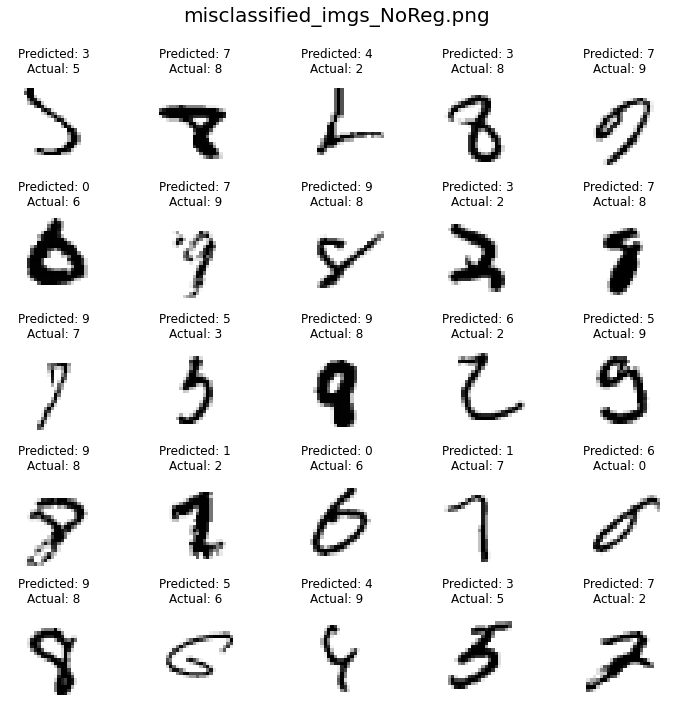

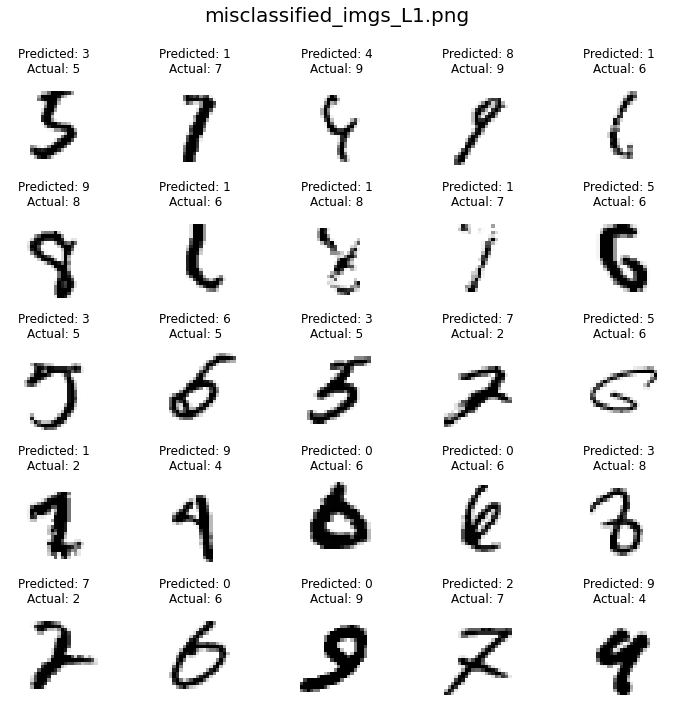

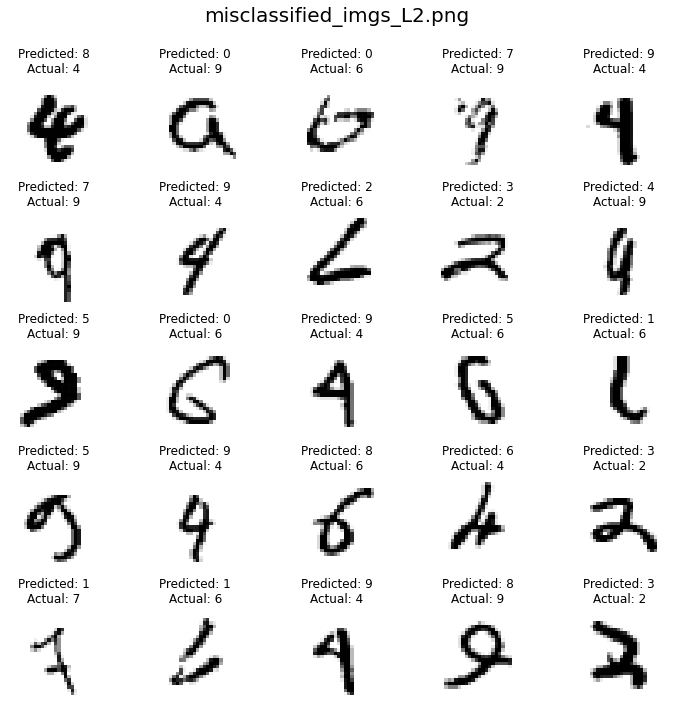

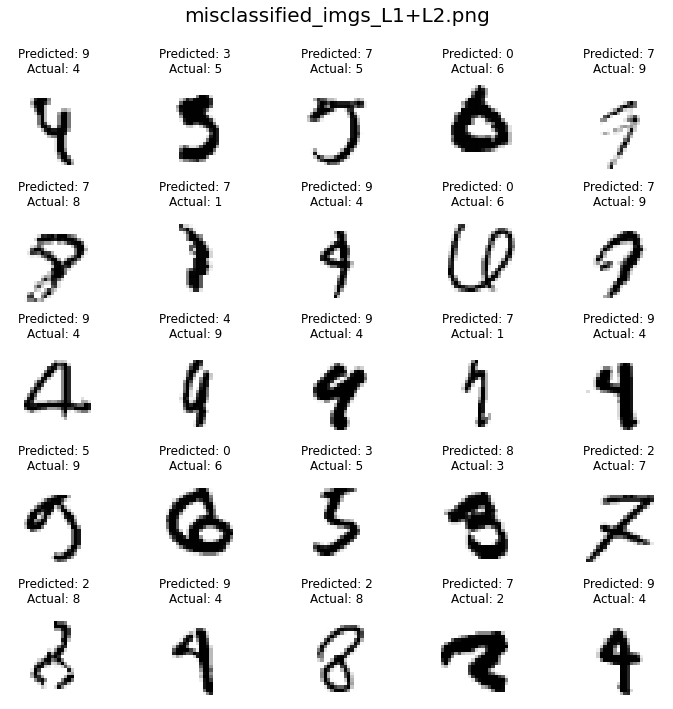

In [13]:
# test_losses
# test_acc
# misclassified_imgs
# ['NoReg', 'L1', 'L2', 'L1+L2']

for i,j in zip(range(4),['NoReg', 'L1', 'L2', 'L1+L2']):
    # print(f'"{i}" misclassified images')
    img_name = "misclassified_imgs_" + j + ".png" 
    plot_misclassified_images(misclassified_imgs_[i], img_name)

# Plotting Loss and Accuracy Plots

In [14]:
def plot_graph(metric_dict,metric):
    fig = plt.figure(figsize=(10, 10))
    
    plt.title(f'Validation %s' % (metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    legend = []
    for i in range(len(metric_dict)):
       x, = plt.plot(metric_dict[i])
       legend.append(x)
    
    plt.legend((k for k in legend), ('NoReg', 'L1=1e-5', 'L2=1e-5', 'L1+L2'))

    fig.savefig(f'val_%s_change.png' % (metric.lower()))

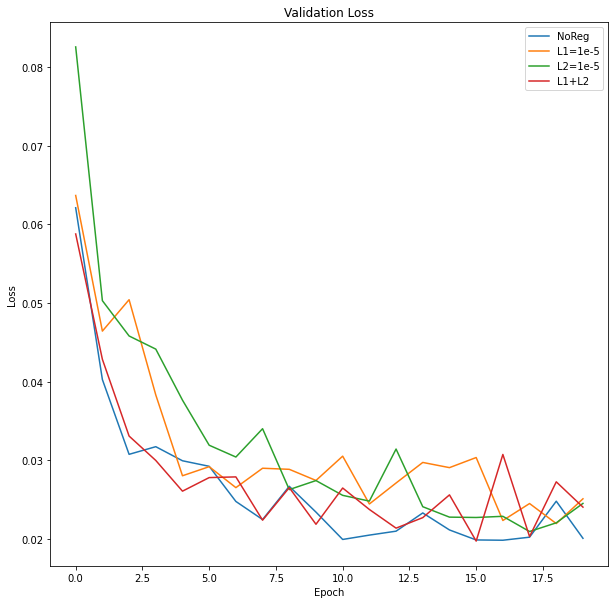

In [15]:
plot_graph(test_losses_, "Loss")

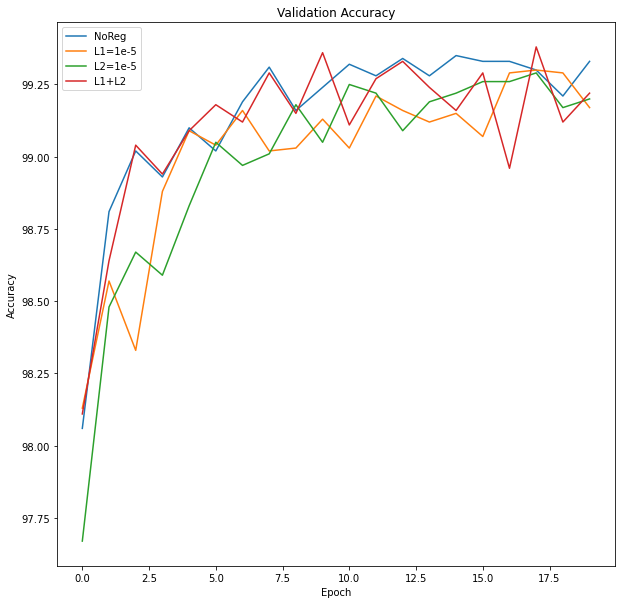

In [16]:
plot_graph(test_acc_, "Accuracy")